# Learn to rank on top of Azure Cognitive Search

This notebook showcases how to train an L2 ranker, using a [Learn to rank](https://en.wikipedia.org/wiki/Learning_to_rank) approach, to be run on top of Azure Cognitive Search. 

Through this experiment, we are going to:
1. Use Azure Cognitive Search's new feature computation capability to extract text-based similarity features that describe query-to-document relationships
2. Do additional feature engineering to enhance our dataset further 
2. Train a model using [XGBOOST](https://xgboost.readthedocs.io/en/latest/)
3. Evaluate the ranking produced by the trained model against the base Azure Cognitive Search ranking using the [NDCG metric](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG).





In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import json
import warnings
warnings.filterwarnings(action='once')

from pathlib import Path
from pprint import pprint

import numpy as np
import requests

import azs_helpers.l2r_helper as azs

from azs_helpers.azure_search_client import azure_search_client as azs_client 
from azs_helpers.azs_msft_docs import azs_msft_docs as azs_docs

### Experiment setup

This experiment uses a dataset containing **7102 articles** from the **docs.microsoft.com** website. Each article contains a title, body, description, list of api names and a url path. Articles were augmented using the [key phrase extraction cognitive skill](https://docs.microsoft.com/en-us/azure/search/cognitive-search-skill-keyphrases) as well as with popular search terms that led to those articles. Additionally, we augmented the articles with easy to compute metadata that will be leveraged when training, such as the number of sections and tables in each article, as well as the normalized page views count.

You can find the full index definition : `azs_helpers\index_schema\docs-multilingual-20200217.json`

```json
{
  "name": "docs-multilingual-20200217",
  "fields": [
    {
      "name": "id",
      "type": "Edm.String",
      "facetable": true,
        ...
    },
    ...
  ]
}
```


The experiment also relies on a labeled training set containing over 900 unique queries evaluated against various articles. We refer to this data as the "judgment" list, which will be used as the ground truth when evaluating ranking. Each query is evaluated against 1 to 10 different documents, and for each, provides a "grade" representing how relevant that specific document is to that query. A value of 10 indicates high relevance, while a value of 1 indicates lower relevance.

The judgement list can be found here: `PATH_TO_JUDGEMENT_LIST.CSV`

#### Configuration
Details and secrets about your search service should be added to a 'config.json' file of this format:

```json
{
   "service_name": "YOUR_SERVICE_NAME",
   "endpoint": "https://YOUR_SERVICE_NAME.search.windows.net",
   "api_version": "2019-05-06-preview",
   "api_key": "YOUR_API_KEY",
   "index_name": "rankingindex-msft-docs"
}
```   

##### Windows

The 'config.json' file should reside in your `%APPDATA%\AzsL2R` directory

Example on Windows: `C:\Users\YourUserName\AppData\Roaming\AzsL2R\config.json`

##### Linux:

The 'config.json' file should reside in your `~/AzsL2R` directory


In [5]:
service_config = {
    "serivce_name": <YOUR SERVICE NAME HERE>,
    "endpoint": <YOUR ENDPOINT HERE>,
    "api_version": "2019-05-06-preview",
    "api_key": <YOUR API KEY HERE>,
    "index_name": “docs-multilingual-20200217"
}

service_config_path = Path.cwd() / 'config' / 'config.json'
with open(service_config_path, 'w') as f:
    json.dump(service_config, f)

SyntaxError: invalid syntax (<ipython-input-5-a0d4ac1ebc17>, line 2)

In [3]:
local_config = {
    "dataset_seed": 42,
    "verbose": False,
    "reindex": False,
    "min_document_count": 7102,
    "local_documents_directory_path" : Path("D:/ranking/doc/extracted_ndcg_light")
}

service_config = 

if sys.platform.startswith('linux'):
    local_config.update({
        'judgement_file_path': Path.cwd() / 'data/msft_docs_labels.csv',
        'service_metadata_config_path': Path.cwd() / 'config/config.json'
    })

elif sys.platform.startswith('windows'):
    local_config.update({
        'judgement_file_path': Path(os.getenv('APPDATA')) / 'AzsL2R/msft_docs_labels.csv',
        'service_metadata_config_path': Path(os.getenv('APPDATA')) / 'AzsL2R/config.json'
    })

azs_service = azs_client.from_json(local_config['service_metadata_config_path'])
msft_docs = azs_docs(local_config['judgement_file_path'])

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Documents/github/wenyang-ltr/config/config.json'

## Service preparation
The following section is meant to setup an index with the required data to run the experiment. 

In [11]:
if not azs_service.index_exist():
    print(f"Index {azs_service.index_name} does not exist in service. Creating.")
    index = msft_docs.create_index(azs_service, schema_file="docs-multilingual-20200217.json")
else:
    print(f"Index {azs_service.index_name} already exists. Skipping creation.")
    
doc_count = azs_service.index_documents_count()
if doc_count < local_config["min_document_count"]: 
    print(f"Index {azs_service.index_name} contains only {doc_count} out of {local_config['min_document_count']} documents. Uploading documents.")
    docs = msft_docs.get_documents_from_local_folder(local_config["local_documents_directory_path"])
    azs_service.upload_documents(docs, 100)
else:
    print(f"Index {azs_service.index_name} contains all {doc_count} documents. Skipping uploading.")

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Succesfully connected to search service 'azslearntorank'
Index docs-multilingual-20200217 already exists. Skipping creation.
Index docs-multilingual-20200217 contains all 7102 documents. Skipping uploading.


### Extracting features from search service

The following functions are designed to efficiently use the Azure Search service to extract document-query features.

1. We filter each queries to only consider the documents we want to judge. This is achieved by adding a **"filter"** clause to our search query which will restrict the results to the group of documents contained in the group of documents we have judgment values for.
2. We set **"featuresMode"** to "enabled". This will tell the search service to return additional features with the results, including per-field similarity scores.
3. We use the **"select"** clause to only return the url of each documents, as well as a few non-text based fields that could potentially be used as features. This will greatly reduce the amount of data that needs to be transfered between the server and the client.
4. We use the **"searchFields"** parameter to select which text-based fields we want to include in the search process. Those fields will be the only ones for which the service will extract text-based features from (such as per-field similarity).

The expect response to this query will have the following format:

```json
    "value": [
     {
        "@search.score": 5.1958685,
        "@search.features": {
            "description_en_us": {
                "uniqueTokenMatches": 1.0,
                "similarityScore": 0.29541412
            },
            "body_en_us": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 0.36644348400000004
            },
            "keyPhrases_en_us": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 0.35014877
            },
            "title_en_us": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 1.75451557
            },
            "urlPath": {
                "uniqueTokenMatches": 2.0,
                "similarityScore": 1.07175103
            },
            "searchTerms": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 1.3575956200000001
            }
        },
        "normalized_pageview": null,
        "tableCount": 0,
        "sectionCount": 7,
        "url_en_us": "https://docs.microsoft.com/en-us/azure/search/"
    }]
```

In [6]:
import json
import pandas as pd

def get_search_results_from_service(service, query, urls_filter):
    search_request_body = {
        "search":azs.escape_query(query),
        "featuresMode": "enabled",
        "select": "title_en_us, url_en_us, sectionCount, tableCount, normalized_pageview", 
        "searchFields": "body_en_us,description_en_us,title_en_us,apiNames,urlPath,searchTerms, keyPhrases_en_us",
        "scoringStatistics": "global",
        "sessionId" : "my_session",
        "top" : 20
    }
    if len(urls_filter) > 0:
        search_request_body["filter"] = " or ".join(f"url_en_us eq '{url}'" for url in urls_filter)

    return service.search(search_request_body)

def get_features_from_service(service, query, group):
    urls = group['url'].values.tolist()
    
    search_results = get_search_results_from_service(service, query, urls)

    # this will flatten the search json response into a panda dataframe
    azs_features = pd.json_normalize(search_results)
    
    # we add the data extracted from azure search to our labeled data by merging them on the "url" field
    merged_results = group.join(azs_features.set_index('url_en_us'), on='url')
    
    # some of the labeled documents in our dataset did not match any documents in the Azure Search instance,
    # we will remove them from our data by dropping any row that did not produce a search score
    return merged_results.dropna(subset=['@search.score'])

### Make parallel calls to the Azure Search service to extract features

To extract all the features from our dataset, we start by grouping the judgment list by query. This will provide us with a list of judged documents for each query. Each call to the Azure Cognitive Search service will use the query from the group,  with filters to make sure we only return the documents from the group. In this dataset, we can expect aproximately 900 queries.

To quickly execute those queries, we setup a thread pool executor which will run the queries in parallel. The level of parallelism can be changed to accomodate different search service capacity.

In [7]:
import concurrent
import datetime
from itertools import chain

query_groups = msft_docs.judgements.groupby('query')

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

executor = concurrent.futures.ThreadPoolExecutor(30)
futures = [executor.submit(get_features_from_service, azs_service, query, group) for (query, group) in query_groups]
concurrent.futures.wait(futures)

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

all_features = pd.concat([future.result() for future in futures if future], sort=False).fillna(0)

2020-04-16 22:44:38
Search request failed with status: 503. Sleeping 100ms. Retrying... Retry count so far 0
Search request failed with status: 503. Sleeping 100ms. Retrying... Retry count so far 0
Search request failed with status: 503. Sleeping 100ms. Retrying... Retry count so far 0
2020-04-16 22:45:22


### Feature engineering

In this section, we can apply additional domain knowledge to do feature engineering. For example, we are going to add the title length, in words and in characters.

We are also going to drop columns of our dataset that we won't be using for the training process, such as raw url, title and query text. 

In [8]:
def customize_features(features):
    
    # adding a query_id column will help us group the data per query later in training
    if 'query_id' not in features:
        features['query_id'] = features.groupby('query').ngroup()
    
    if ('title_en_us' in features):
        features['title_en_us'] = features['title_en_us'].map(lambda title: str(title))
        features['title_length_in_words'] = features['title_en_us'].map(lambda title: len(title.split()))
        features['title_length_in_chars'] = features['title_en_us'].map(lambda title: len(title))

    # Discard the columns that we no longer need
    features = features.drop(['query', 'url', 'title_en_us'], axis=1, errors='ignore')
    return features

all_features = customize_features(all_features)
print("All features collected:")
print(all_features.columns.values)

All features collected:
['grade' '@search.score' 'normalized_pageview' 'tableCount' 'sectionCount'
 '@search.features.body_en_us.uniqueTokenMatches'
 '@search.features.body_en_us.similarityScore'
 '@search.features.description_en_us.uniqueTokenMatches'
 '@search.features.description_en_us.similarityScore'
 '@search.features.keyPhrases_en_us.uniqueTokenMatches'
 '@search.features.keyPhrases_en_us.similarityScore'
 '@search.features.title_en_us.uniqueTokenMatches'
 '@search.features.title_en_us.similarityScore'
 '@search.features.searchTerms.uniqueTokenMatches'
 '@search.features.searchTerms.similarityScore'
 '@search.features.urlPath.uniqueTokenMatches'
 '@search.features.urlPath.similarityScore' 'query_id'
 'title_length_in_words' 'title_length_in_chars']


### Visualize our Dataset

Let's pay attention to a few things in particular:

- The **grade** column represents the ground truth rating for this document, and it is an [ordinal variable](https://en.wikipedia.org/wiki/Ordinal_data) ranging from **1 ~ 10**, from least relevant to most relevant. A grade of '10' means that the document is most relevant, while a grade of '1' means that the document is least relevant.
- Some queries have less than 10 documents. We'll have to keep this fact in mind when preparing our data.

In [9]:
print(f"Number of unique queries: {len(all_features.groupby('query_id'))}")
print(f"Number of documents: {len(all_features)}")
print(f"Number of features: {len(all_features.columns)}")

all_features

Number of unique queries: 981
Number of documents: 8973
Number of features: 20


,grade,@search.score,normalized_pageview,tableCount,sectionCount,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,@search.features.description_en_us.uniqueTokenMatches,@search.features.description_en_us.similarityScore,@search.features.keyPhrases_en_us.uniqueTokenMatches,@search.features.keyPhrases_en_us.similarityScore,@search.features.title_en_us.uniqueTokenMatches,@search.features.title_en_us.similarityScore,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,query_id,title_length_in_words,title_length_in_chars
4130,10,0.101192,222.160000,1.0,13.0,1.0,0.101192,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,3,28
4132,8,0.155940,1.440000,0.0,0.0,1.0,0.155940,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,8,44
4134,6,0.043148,3.600000,1.0,2.0,1.0,0.043148,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,5,40
4136,4,0.233910,2.680000,0.0,2.0,1.0,0.233910,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,5,32
4137,3,0.090593,2.460000,0.0,2.0,1.0,0.090593,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0,8,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,5,3.183052,0.276596,0.0,3.0,1.0,0.339155,0.0,0.000000,1.0,0.434516,1.0,1.376789,0.0,0.000000,1.0,1.032592,980,3,28
1966,4,5.304070,14.320000,0.0,9.0,1.0,0.306429,1.0,1.005799,1.0,0.356660,1.0,0.860493,1.0,1.742096,1.0,1.032592,980,10,75
1967,3,4.034551,0.460000,1.0,5.0,1.0,0.482078,1.0,0.995691,1.0,0.491599,1.0,1.032592,0.0,0.000000,1.0,1.032592,980,3,58
1968,2,2.886207,8.640000,0.0,3.0,1.0,0.169577,0.0,0.000000,1.0,0.307249,1.0,1.376789,0.0,0.000000,1.0,1.032592,980,3,31


### Visualize Azure Cognitive Search NDCG

[**Normalized Discounted Cumulative Gain (NDCG)**](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Discounted_cumulative_gain) is a common metric used to evaluate search ranking systems.  Using `@search.score` returned from the service, we can calculate and visualize Azure Search's NDCG. This will be the baseline to beat with our ranking model.

- `NDCG@K` denotes the NDCG for lists of K length. For example:
    - `NDCG@1` denotes calculating NDCG for a list containing only the top result in a search query
    - `NDCG@5` would refer to the NDCG for a list containing the top 5 results

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,baseline
1,0.692539
2,0.715180
3,0.727685
4,0.745287
5,0.762492
6,0.783064
7,0.805746
8,0.829268
9,0.854059
10,0.872828


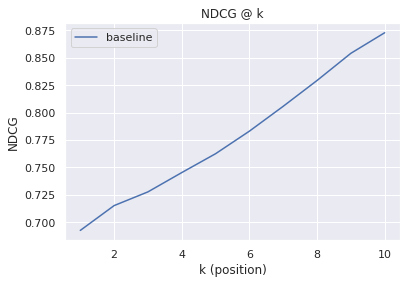

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

query_groups_with_azs_ranking = all_features.sort_values(['@search.score'], ascending=False).groupby('query_id')
ndcg_inputs = [[doc['grade'] for _, doc in group.iterrows()] for query_id, group in query_groups_with_azs_ranking]
original_ndcg = azs.evaluate_ndcg(k_start=1, k_end=10, baseline=ndcg_inputs, plot=True)

## Feature Normalization

Similarity scores are computed to be compared within the context of a single search query, where all documents are evaluated against the same search terms. The range of those scores fluctuates depending on what terms are being searched (for example, common terms often yield to lower similarity scores, since their document frenquency is higher).

To address this problem, we are going to normalize most of our features using the [minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html) scaler, which will be applied at the query level group, so that all documents associated with a particular query will have their feature values scaled from 0 to 1.

For features with outlier values, such as `normalized_pageview`, we will use the [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html).


In [11]:
from sklearn.preprocessing import minmax_scale, QuantileTransformer, quantile_transform

def normalize_features(features):
    query_groups = features.groupby('query_id')

    for feature in features.columns:
        if feature not in['normalized_pageview', 'grade', 'query_id'] and features.dtypes[feature] in [float, int]:
            features[feature] = query_groups[feature].transform(lambda x: minmax_scale(x.astype(float)))
    
    if 'normalized_pageview' in features.columns:
        features['normalized_pageview'] = query_groups['normalized_pageview'].transform(
            lambda x: np.concatenate(
                QuantileTransformer(n_quantiles=min(len(x), 4)).fit_transform(x.values.reshape(-1,1))
            )
        )
    
    return features
    
df = normalize_features(all_features)
df.head(5)

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,grade,@search.score,normalized_pageview,tableCount,sectionCount,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,@search.features.description_en_us.uniqueTokenMatches,@search.features.description_en_us.similarityScore,@search.features.keyPhrases_en_us.uniqueTokenMatches,@search.features.keyPhrases_en_us.similarityScore,@search.features.title_en_us.uniqueTokenMatches,@search.features.title_en_us.similarityScore,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,query_id,title_length_in_words,title_length_in_chars
4130,10,0.304274,9.999999e-01,0.333333,1.000000,0.0,0.304274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.285714,0.488889
4132,8,0.591270,1.000000e-07,0.000000,0.000000,0.0,0.591270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.844444
4134,6,0.000000,3.521704e-01,0.333333,0.153846,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.571429,0.755556
4136,4,1.000000,3.333333e-01,0.000000,0.153846,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.571429,0.577778
4137,3,0.248711,2.741935e-01,0.000000,0.153846,0.0,0.248711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,1.000000


## Split dataset into features and judgments

The machine learning libraries we're using expect us to separate our training data into features $X$ and judgment values $y$. Let's do that real quick: 


In [12]:
X, y = df.drop(columns=['grade', 'query_id'], axis=1), df.grade

#### Computing Quadratic Interaction Features

There are a few features that may have interactions with each other. Let's identify them and generate quadratic interaction pairs:

### Hold out a portion of the data for testing.

We need to hold out part of the data to validate that our model works.

For this tutorial, we will hold out **10%** of the data using `scikit-learn.model_selection.GroupShuffleSplit`. This means that the model will use **90%** of the queries for training & validation, while **10%** of the queries (that the model has never seen before) will be used to evaluate the final model's performance.

#### Query labels for documents

Our data preparation and model training process must be aware of query-document relationships in our dataset for accurate training results, so we'll need to pass in the query labels (`query_ids`) as well. The reason this is important is because the loss function used for optimization depends on the NDCG. As discussed above, the NDCG is a metric which indicates how close is an ordered list to its ideal order. To achieve this, the model needs to be aware of how to create those lists out of the training set, which can be achieved by grouping the data using the query_id.

Read the following references for more information:

- [Scikit-Learn: Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Scikit-Learn: GroupShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#group-shuffle-split)

In [13]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# Hold out 10% of our queries in the test set.
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=local_config['dataset_seed'])

# Query labels for each document in our dataset.
query_ids = df['query_id'].to_numpy()

train_index, test_index = next(gss.split(X, y, groups=query_ids))
print(f"Number of samples in train: {len(train_index)}")
print(f"Number of samples in test: {len(test_index)}")

# Split our features, judgment values, and query labels into train & test sets.
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
query_ids_train, query_ids_test = query_ids[train_index], query_ids[test_index]

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Number of samples in train: 8059
Number of samples in test: 914


# Experimentation

Now that we've completed our feature engineering steps, we can move on to running our experiment. We'll be using the open-source [XGBoost library](https://xgboost.readthedocs.io/en/latest/index.html), which includes a few implementations of [**Pairwise**](https://en.wikipedia.org/wiki/Learning_to_rank#Pairwise_approach) and [**Listwise**](https://en.wikipedia.org/wiki/Learning_to_rank#Listwise_approach) ranking algorithms.

By setting `'objective': 'rank:ndcg'` in the model constructor, we've chosen to use the [LambdaMART](https://www.microsoft.com/en-us/research/publication/from-ranknet-to-lambdarank-to-lambdamart-an-overview/) algorithm to maximize **listwise** [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain).

Another objective function that can be used for this problem is `rank:pairwise`, which will perform **pairwise** training instead of listwise training.

### Further Reading:
- [Learning to Rank: From Pairwise Approach to Listwise Approach](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-2007-40.pdf)
- XGBoost Documentation links:
    - [XGBRanker Class](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRanker)
    - [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [14]:
import xgboost as xgb

params = {'objective': 'rank:ndcg', 'learning_rate': 0.1,
          'gamma': 1.0, 'min_child_weight': 0.1,
          'max_depth': 8, 'n_estimators': 500}

ranker = xgb.XGBRanker(**params)
ranker

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


XGBRanker(base_score=None, booster=None, colsample_bylevel=None,
     colsample_bynode=None, colsample_bytree=None, gamma=1.0, gpu_id=None,
     importance_type='gain', interaction_constraints=None,
     learning_rate=0.1, max_delta_step=None, max_depth=8,
     min_child_weight=0.1, missing=nan, monotone_constraints=None,
     n_estimators=500, n_jobs=None, num_parallel_tree=None,
     objective='rank:ndcg', random_state=None, reg_alpha=None,
     reg_lambda=None, scale_pos_weight=None, subsample=None,
     tree_method=None, validate_parameters=False, verbosity=None)

### Train with K-Fold Cross Validation

Let's train with K-fold cross validation with `K=9`. We'll be using `scikit-learn`'s [GroupKFold class](https://scikit-learn.org/stable/modules/cross_validation.html#group-k-fold) to split our training data into 9 approximately even-sized portions. `GroupKFold` ensures that all documents for a particular query remain within the same fold. Before we can get started, though, we'll need to augment our query labels for training.

#### Computing Document counts per Query

During the training phase, we need to transform our query labels to be compatible with XGBoost. The `GroupKFold` cross-validation tool provided by `scikit-learn` expects a group (or query) label for every document in the dataset. We've already provided this in the form of `query_ids`.

Let's take a look at the example below. Given a simple dataset of 3 queries:

- Query 1: [doc1, doc2, doc3]
- Query 2: [doc4]
- Query 3: [doc5, doc6]

**`scikit-learn` expects the following format**:

```python
# query_ids = [query1, query1, query1, query2, query3, query3]
query_ids = [1, 1, 1, 2, 3, 3]
```

**`xgboost` expects the following format**:

```python
query_doc_counts = [3, 1, 2]
```
    
`xgboost` expects document counts for each query (as opposed to a query label for every document), sorted by query. We can take our scikit-learn compatible query labels and aggregate them using numpy, as follows:

```python
labels, query_doc_counts = np.unique(query_ids, return_counts=True)
```

or, alternatively:
```python
query_doc_counts = np.unique(query_group_labels, return_counts=True)[1]
```

For reference, please refer to the [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRanker)

### Calculating our Results
Calling `ranker.predict(X_test)` here will allow us to get all of the results. Since `xgb_scores` is a flat list of scores that aren't grouped by query, we'll need to slice it with sliding windows to create predicted rankings for each query. Feel free to read the docstring of `azs_helpers.l2r_helper.compute_judgments_after_training` for more information.

We expect uneven group sizes like the following:

- Query 1: 10 search results
- Query 2: 8 search results
- Query 3: 7 search results

In [15]:
from sklearn.model_selection import GroupKFold

def calculate_ndcg_for_experiment(ranker, X, y, query_ids):
    n_splits = 9
    group_kfold = GroupKFold(n_splits)

    ndcg_results = []

    for train_index, valid_index in group_kfold.split(X, y, groups=query_ids):
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
        
        # XGBoost expects query counts instead of query labels.
        # https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
        train_groups_xgb = np.unique(query_ids[train_index], return_counts=True)[1]
        valid_groups_xgb = np.unique(query_ids[valid_index], return_counts=True)[1]
        
        ranker.fit(X_train_fold, y_train_fold, train_groups_xgb,
                   eval_set=[(X_valid_fold, y_valid_fold)], eval_group=[valid_groups_xgb],
                   eval_metric='ndcg',
                   verbose=False)
        xgb_scores = ranker.predict(X_valid_fold)
        model_judgments, azs_judgments, baseline = azs.compute_judgments_after_training(xgb_scores, valid_groups_xgb, X_valid_fold, y_valid_fold)
        ndcg_results_for_fold = azs.evaluate_ndcg(k_start=1, k_end=10, azs=azs_judgments, predicted=model_judgments)
        ndcg_results.append(ndcg_results_for_fold)

    return ndcg_results

ndcg_results = calculate_ndcg_for_experiment(ranker, X_train, y_train, query_ids_train)

### Visualize Cross-Validation Results

Now that we've trained our model multiple times, we can visualize the training results.

Datapoints represent the mean across all training runs, while vertical bars are the standard deviation.

----------- NDCG mean across all 9 folds --------------


,azs,predicted
1,0.714540,0.806488
2,0.730792,0.792065
3,0.738464,0.793237
4,0.750169,0.795892
5,0.768586,0.807530
6,0.787174,0.822534
7,0.807251,0.840211
8,0.831313,0.861243
9,0.856160,0.882625
10,0.876655,0.900327


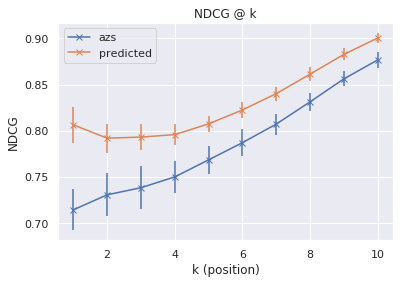

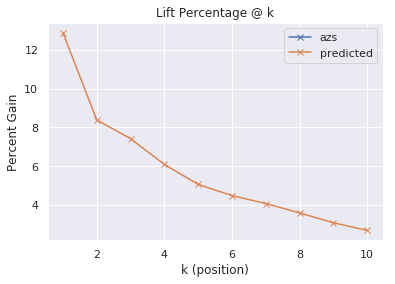

In [17]:
azs.show_ndcg_results(ndcg_results, 1, 10)

### Putting it all together

Now that we're confident that our model performs better than Azure Search's built-in retrieval algorithm, let's run it against the test set! This time around, we'll be using all of the training data available to us.

,azs,predicted
1,0.705892,0.820707
2,0.723057,0.802453
3,0.736393,0.801120
4,0.734649,0.799540
5,0.760910,0.813732
6,0.775166,0.825397
7,0.793836,0.839989
8,0.823484,0.861028
9,0.853898,0.885922
10,0.871519,0.902978


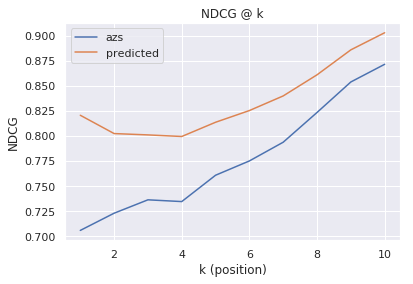

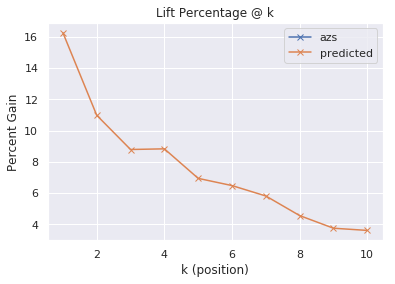

In [18]:
train_groups_xgb = np.unique(query_ids_train, return_counts=True)[1]
test_groups_xgb = np.unique(query_ids_test, return_counts=True)[1]

ranker.fit(X_train, y_train, train_groups_xgb,
           eval_metric='ndcg',
           verbose=False)

xgb_scores = ranker.predict(X_test)
model_judgments, azs_judgments, baseline = azs.compute_judgments_after_training(xgb_scores, test_groups_xgb, X_test, y_test)

test_ndcg_results = azs.evaluate_ndcg(k_start=1, k_end=10, plot=True, show_lift=True, azs=azs_judgments, predicted=model_judgments)

### Feature Importances
We can view which features ended up being the most important in our trained model:

In [19]:
feature_importances = dict(zip(X_train.columns, ranker.feature_importances_))
feature_importances_sorted = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
feature_importances_sorted

{'@search.features.searchTerms.similarityScore': 0.23081936,
 'normalized_pageview': 0.10309062,
 '@search.score': 0.068645306,
 '@search.features.description_en_us.uniqueTokenMatches': 0.046364766,
 '@search.features.body_en_us.uniqueTokenMatches': 0.045432895,
 '@search.features.urlPath.similarityScore': 0.04401823,
 '@search.features.body_en_us.similarityScore': 0.04163851,
 'title_length_in_words': 0.041023325,
 '@search.features.keyPhrases_en_us.similarityScore': 0.03994777,
 '@search.features.title_en_us.similarityScore': 0.03989109,
 'title_length_in_chars': 0.039845694,
 '@search.features.keyPhrases_en_us.uniqueTokenMatches': 0.039070953,
 '@search.features.description_en_us.similarityScore': 0.039029673,
 '@search.features.searchTerms.uniqueTokenMatches': 0.03823663,
 'sectionCount': 0.03717545,
 '@search.features.urlPath.uniqueTokenMatches': 0.03624796,
 'tableCount': 0.035576858,
 '@search.features.title_en_us.uniqueTokenMatches': 0.033944927}

### How to re-rank a search request's results using our trained model
When re-ranking an Azure Search query, we need to go through the same process to transform the results into features as we did for our training data. 

This means

1. Get features from Azure Search
2. Compute any additional features that was used int raining
3. Apply the same level of normalization 

Once we get the features in the expected format, we can feed them into the trained model to infer a new order, which will be used to re-rank our results.

In [20]:
def rerank_search_query(service, query, model, expected_features):
    expected_features_format = pd.DataFrame(columns = expected_features, dtype='float64')
    
    json_search_results = get_search_results_from_service(service, query, [])
    search_results = pd.json_normalize(json_search_results).fillna(0)
    search_results["query"] = query

    search_features = customize_features(search_results.drop(columns=['url_en_us'], axis=1))
    normalized_search_features = normalize_features(expected_features_format.append(search_features))
    
    prediction_score = model.predict(normalized_search_features.drop(columns=['query_id'], axis=1, errors='ignore'))
    search_results['prediction'] = prediction_score

    new_df = pd.DataFrame()
    new_df['Base Azure Search order'] = search_results.apply(lambda row: "{0}\n{1}".format(row['title_en_us'], row['url_en_us']), axis=1) 
    new_df['Trained model order'] = search_results.sort_values('prediction', ascending=False).apply(lambda row: "{0}\n{1}".format(row['title_en_us'], row['url_en_us']), axis=1).tolist() #['title_en_us'].tolist()

    return new_df

azs.pretty_print(rerank_search_query(azs_service, 'Windows Server 2019', ranker, X.columns))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


,Base Azure Search order,Trained model order
0,Upgrade Windows Server 2016 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2016-to-2019,Windows Server 2019 System Requirementshttps://docs.microsoft.com/en-us/windows-server/get-started-19/sys-reqs-19
1,Upgrade Windows Server 2012 R2 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2012r2-to-2019,Windows Server Documentation - Microsoft Docshttps://docs.microsoft.com/en-us/windows-server/
2,Overview of Windows Server IoT 2019 - Windows IoThttps://docs.microsoft.com/en-us/windows/iot-core/windows-server,What's new in Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/whats-new-19
3,Upgrade to SharePoint Server 2019https://docs.microsoft.com/en-us/sharepoint/upgrade-and-update/upgrade-to-sharepoint-server-2019,Comparison of Standard and Datacenter editions of Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/editions-comparison-19
4,Windows Server 2019 System Requirementshttps://docs.microsoft.com/en-us/windows-server/get-started-19/sys-reqs-19,Visual Studio 2019 version 16.4 Release Noteshttps://docs.microsoft.com/en-us/visualstudio/releases/2019/release-notes
5,Windows Defender Antivirus on Windows Server 2016 and 2019 - Windows securityhttps://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-antivirus/windows-defender-antivirus-on-windows-server-2016,"Install, upgrade, or migrate to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/install-upgrade-migrate-19"
6,What's new in Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/whats-new-19,Overview of Windows Server IoT 2019 - Windows IoThttps://docs.microsoft.com/en-us/windows/iot-core/windows-server
7,What's new in Windows 10 Enterprise 2019 LTSC - What's new in Windowshttps://docs.microsoft.com/en-us/windows/whats-new/ltsc/whats-new-windows-10-2019,Upgrade Windows Server 2016 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2016-to-2019
8,Visual Studio 2019 System Requirementshttps://docs.microsoft.com/en-us/visualstudio/releases/2019/system-requirements,Upgrade to SharePoint Server 2019https://docs.microsoft.com/en-us/sharepoint/upgrade-and-update/upgrade-to-sharepoint-server-2019
9,"Install, upgrade, or migrate to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/get-started-19/install-upgrade-migrate-19",Upgrade Windows Server 2012 R2 to Windows Server 2019https://docs.microsoft.com/en-us/windows-server/upgrade/upgrade-2012r2-to-2019
